In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#sys.path.append("/home/cusp/fbianco/choroplethNYC/")
import choroplethNYC as cp
#from importlib import reload


In [3]:
os.getenv("PUIDATA")

'/Users/fbb/Dropbox//UI/PUIdata'

## This notebook is designed to pratice with both geopandas and census data.  This is a simple spatial exploratory analysis of census data. The goal is to assess wheather the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

## THE CENSUS: 
make sure you do the assigned reading about the census. Census data are a national trasure! The census is a survey  designed to collect data on every person that lives in the USA every 10 years. The Census Bureau collects data, designes aggregation areas (the census blocks and tracts for example, which are designed for maximal homogeneity across all features). However, the Census Bureau does not only collect and aggregate data every 10 years, it also collects the America Community Survey every 5 years, and some more restricted survey on an annual bases. The 1 year survey data is what we will use: https://www.census.gov/services/index.html


# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will leat to an estimat (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

download it as a shape file. When you download a shapefile you actually download a zipped folder which contains the shape file and other files that are necessary to read the shape file in. You can do that with the urllib library in python 3 with the function 

        urllib.request.urlretrieve(url, "file.gz")

then unpack the data into your PUIdata directory, then read it in with geopandas, reading in the shape file with the function 

        geopandas.GeoDataFrame.from_file(filename)

PUMAs were first created for the 1990 Census. PUMAs are identified by a specific 4 numbers id. In the shapefile foung at data.cityofnewyork.us the id is named "puma" and it is in fact a 4 digits number. You can read it in as an integer (although of course it is a categorical variable inherently!). Often the PUMA id is found in conjunction with the 3 numbers state id, leading to a 7 numbers identification. The id for the State of NY is 036. See this link for more: https://www.census.gov/geo/reference/geoidentifiers.html


In [4]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")


('file.gz', <http.client.HTTPMessage at 0x116d242e8>)

In [5]:
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_13de04b4-6f96-4e9c-a840-d3a1f7243dcf.dbf  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_13de04b4-6f96-4e9c-a840-d3a1f7243dcf.shp  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_13de04b4-6f96-4e9c-a840-d3a1f7243dcf.shx  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_13de04b4-6f96-4e9c-a840-d3a1f7243dcf.prj  


In [7]:
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                     "geo_export_13de04b4-6f96-4e9c-a840-d3a1f7243dcf.shp")
#                    "geo_export_4777e173-f310-449c-9fca-1b10b8d6b35a.shp")

In [8]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [9]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2  plot the PUMA NYC regions

you can use the geopandas function plot. 
What is the appropriate plot to just show the shape of the PUMA regions? A choropleth could be ok, but it is better to just draw the contours of the region, since we do not want to highlight some regions over others by color choices. 

(Note: a while ago I wrote a quick function that plots choropleths and maps of NYC specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city and you are welcome to use it: https://github.com/fedhere/choroplethNYC.)

Your map should look someting like:

In [10]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
pumashp.puma = pumashp.puma.astype(int)

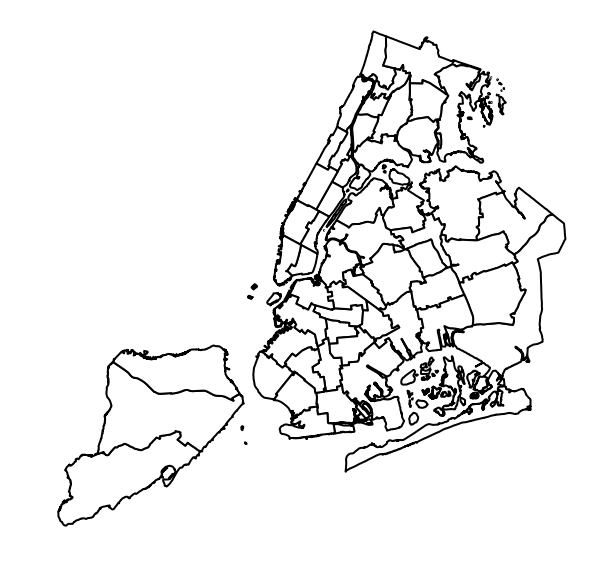

In [11]:
# using the built in plot function as pumashp.plot(pumashp....)
# using a choroplethNYC function that FBB wrote
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

##### Fig. 1: The NYC Public Use Microdata Areas (PUMAs). NYC is divided in 55 PUMAs ranging in size reflecting the population density variations in NYC (since PUMAs are constructed to collect a fix number of inhabitants).

# 2. American Fact Finder data on percentage of houses with broadband internet access

Download the table of data from 2016 for NYC: you want to obtain data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

This may be tricky. But familiarizing with Census and American Commjunity Survey data is super important for urban science. Here you should use the API, but you should also practice interacting with the website: 

You  should read the datta in thgouth the API but also download the data manually and compare the two datasets.

## 2.1 Get data with American Fact Finder (AFF) API: 
you can request an API key, although I think it is not necessary for this search (but it is good to practice). Obtain a key and save it into a python file. DO NOT UPLOAD THE FILE CONTAINING THE API KEY TO GITHUB. Keep your API keys private. 

In [12]:
from censusAPI import myAPI

The internet subscription by household is data surveyd annually. You can find out what are the features that you can query through the API for the annually surveyed data at this url: https://api.census.gov/data/2016/acs/acs1/variables.json

read it in as a jason file - you can do it with pandas, but it is slow. You can do it as I do below with the request package

In [13]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [14]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

You need two features: **total number of households**, and **number of households with broadband access**

Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "\_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations  (rows that start with "B28002") that include the word "Broadband" in the description.

The syntax is a lost comprehension:

        as = \[a for a in listOfAs\] 

is simply a compact way to write

        as = \[\]
        for a in listOfAs:
            as.append(a)
            
with an if statement tha selects broadband         

In [15]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the \_001 variable (B28002_001 in this case). "E" stands for *estimate*. M stands for *margin of error*, EA *estimate annotations*, MA *margin of error annotations*. You want the estimate for this exercise. 

In [16]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

Similarly, choose the fractions of houses with any "With an Internet subscription!!Broadband of any type"

In [17]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

Now that you have the variable names use them to extract the relevant data with the ACS API. 

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=\[variable Name\],NAME

geometry: for=\[geometry\]:\[desired geometry values\]in=\[larger geometry\]:\[desired larger geometry values\]

API key: key:\[api key\]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS

state:36 is New York State

In [18]:
# delete
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get="  + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [19]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [20]:
#merge number of households w broadband access and total number of households
pumaBB = pumaBB.merge(pumaPP).drop("Unnamed: 4", axis=1)

In [21]:
#percentage of households w broadband
pumaBB['pcBB'] = pumaBB.B28002_004E.astype(float) / pumaBB.B28002_001E * 100

In [22]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It's compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all 

    - Topics: Product Type -> Geography Comparison Table 
    
select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION  at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.
    
Your table shold be labeled as: GCT2801	

One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste!
Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

1. ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following *sftp* command
        
        fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu
    
2. Input your password
            
        Password: 
        Connected to staging.cusp.nyu.edu.

   This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)
    
        sftp> cd /home/fbianco/PUIdata             
        
3. Use the sftp command _put_ to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)
    
        sftp> put /Users/fbianco/Downloads/aff_download.zip
        
You should see:

            Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need.

In [23]:
# delete
!unzip   -d $PUIDATA $PUIDATA/aff_download.zip

unzip:  cannot find or open /Users/fbb/Dropbox//UI/PUIdata/aff_download.zip, /Users/fbb/Dropbox//UI/PUIdata/aff_download.zip.zip or /Users/fbb/Dropbox//UI/PUIdata/aff_download.zip.ZIP.


In [24]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


notice 2 things:
    - that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
    - that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.
    
In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id 

In [25]:
bbpc.rename(columns={"GCT_STUB.target-geo-id2":"gid"}, inplace=True)
bbpc.drop(0, inplace=True)
bbpc

,gid,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9
6,0100400,69.2,3.6
7,0100500,81.3,2.8
8,0100600,68.6,2.6
9,0100700,70.3,3.1
10,0100800,74.7,3.4


In [26]:
bbpc.gid = bbpc.gid.astype(int)
bbpc = bbpc[(bbpc.gid > 3600000) & (bbpc.gid < 5700000)]
bbpc

,gid,HC01,HC02
1413,3600100,80.6,2.6
1414,3600200,75.7,2.2
1415,3600300,79.8,2.6
1416,3600401,81.4,2.4
1417,3600402,78.2,2.3
1418,3600403,76.6,2.2
1419,3600500,81.4,2.1
1420,3600600,84.4,2.3
1421,3600701,67.0,3.0
1422,3600702,84.0,2.7


In [27]:
bbpc["gid"]

1413    3600100
1414    3600200
1415    3600300
1416    3600401
1417    3600402
1418    3600403
1419    3600500
1420    3600600
1421    3600701
1422    3600702
1423    3600703
1424    3600704
1425    3600800
1426    3600901
1427    3600902
1428    3600903
1429    3600904
1430    3600905
1431    3600906
1432    3601000
1433    3601101
1434    3601102
1435    3601201
1436    3601202
1437    3601203
1438    3601204
1439    3601205
1440    3601206
1441    3601207
1442    3601300
         ...   
2372    5501401
2373    5501500
2374    5501501
2375    5501600
2376    5501601
2377    5502400
2378    5502500
2379    5510000
2380    5520000
2381    5530000
2382    5540101
2383    5540301
2384    5540701
2385    5541001
2386    5541002
2387    5541003
2388    5541004
2389    5541005
2390    5550000
2391    5555101
2392    5555102
2393    5555103
2394    5570101
2395    5570201
2396    5570301
2398    5600100
2399    5600200
2400    5600300
2401    5600400
2402    5600500
Name: gid, Length: 972, 

In [28]:
bbpc["gid"] = bbpc.gid - 3600000
bbpc["HC01"] = bbpc["HC01"].astype(float)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
bbpc["gid"]

1413        100
1414        200
1415        300
1416        401
1417        402
1418        403
1419        500
1420        600
1421        701
1422        702
1423        703
1424        704
1425        800
1426        901
1427        902
1428        903
1429        904
1430        905
1431        906
1432       1000
1433       1101
1434       1102
1435       1201
1436       1202
1437       1203
1438       1204
1439       1205
1440       1206
1441       1207
1442       1300
         ...   
2372    1901401
2373    1901500
2374    1901501
2375    1901600
2376    1901601
2377    1902400
2378    1902500
2379    1910000
2380    1920000
2381    1930000
2382    1940101
2383    1940301
2384    1940701
2385    1941001
2386    1941002
2387    1941003
2388    1941004
2389    1941005
2390    1950000
2391    1955101
2392    1955102
2393    1955103
2394    1970101
2395    1970201
2396    1970301
2398    2000100
2399    2000200
2400    2000300
2401    2000400
2402    2000500
Name: gid, Length: 972, 

## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [30]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))
diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


In [31]:
pumaBB

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656
5,32221,"Otsego, Schoharie, Oneida (South) & Herkimer (...",36,403,42081,76.568998
6,41386,"Jefferson & Lewis Counties PUMA, New York",36,500,50860,81.372395
7,37692,"Oswego County PUMA, New York",36,600,44633,84.448726
8,37719,"Onondaga County (Central)--Syracuse City PUMA,...",36,701,56295,67.002398
9,40309,"Onondaga County (North) PUMA, New York",36,702,47988,83.998083


In [32]:
pumaBB['public use microdata area'].max()

4114

# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

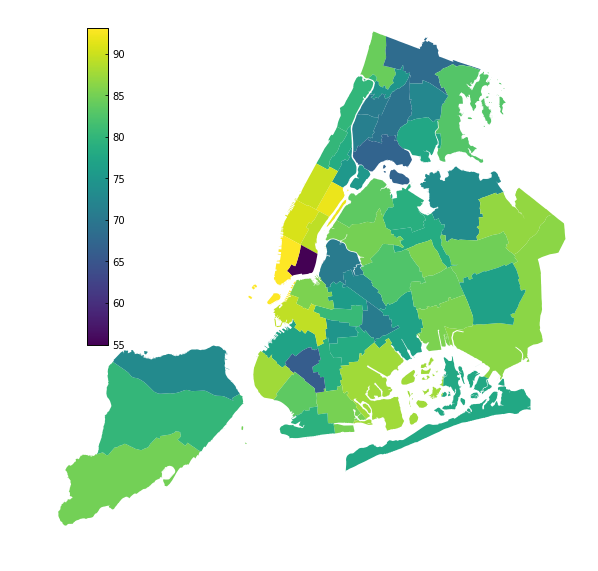

In [33]:
#choropleth of the percentage of internet axcess
pumashp = pumashp.merge(pumaBB, left_on="puma", 
                   right_on="public use microdata area")

cp.choroplethNYC(pumashp,
                 column="pcBB", #scheme='equal_interval', k=4,
                                   #legend=True, 
                 cmap="viridis");

##### Fig. 2: Percentage of households with broadband access (of any kind) at the PUMA granularity level. Percentages range from 55 to >95%, however the only PUMA with less than ~65% households with broadband access is the lower east side. This is a known statistical outliers in NYC on many, if not most socioeconomic features, and it is the site of a large complex of housing projects.


# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe
read it in from the HW9_fb55 folder in :
https://github.com/fedhere/PUI2017_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [34]:
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv", index_col=0)

In [35]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab
    linkNYC.crs = ...

In [36]:
# combine lat and lon to one column
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [37]:
linkNYC = gpd.GeoDataFrame(linkNYC)
linkNYC.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

In [38]:
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.94223923850001, 40.701930343899996)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

In [39]:
linkNYC.date_link_ = pd.to_datetime(linkNYC.date_link_)

In [40]:
type(linkNYC.date_link_.values[0])

numpy.datetime64

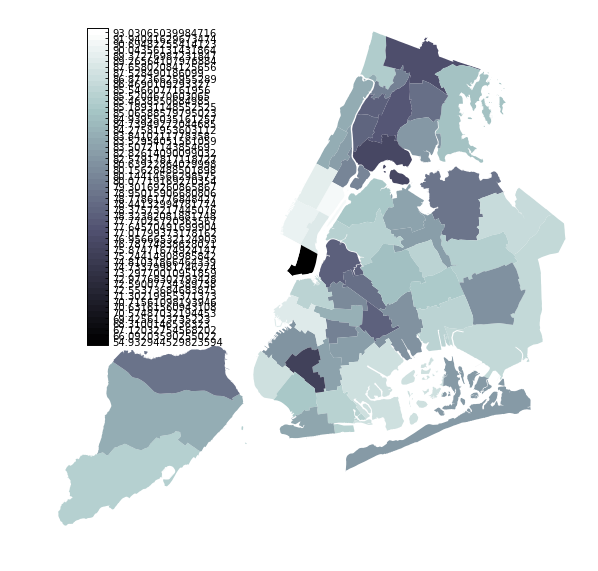

In [41]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
cp.choroplethNYC(pumashp,
                 column="pcBB", ax=ax, kind="discrete", k=2, #scheme='equal_interval', k=4,
                                   #legend=True, 
                 cmap="bone");
#cp.choroplethNYC(pumashp, column="pcBB", scheme='equal_interval', k=5,
#             cmap="bone", ax=ax, edgecolor="black", cb=True)
#linkNYC.plot(ax=ax, marker='o', c="date_link_", 
#             markersize=5, cmap="OrRd");

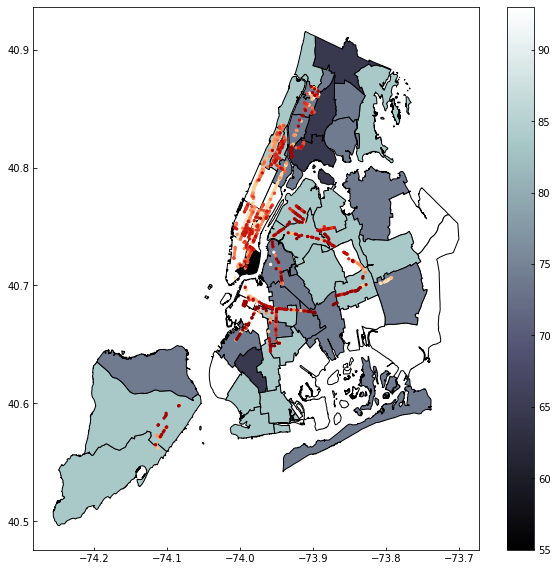

In [42]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
p = pumashp.plot(column="pcBB", scheme='equal_interval',ax=ax, k=5, edgecolor="black", cmap='bone')
linkNYC.plot(ax=ax, marker='o', c="date_link_", 
             markersize=5, cmap="OrRd");
norm = Normalize(vmin=pumashp.pcBB.min(), vmax=pumashp.pcBB.max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='bone')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap)


In [43]:
pumashp.plot?

##### Fig. 3: Location of linkNYC hubs (dots) overplotted on a map of NYC color-coded to reflect the percentage of houses with broadband internet acces at the PUMA level, in 5 equal intervals (darker indicating a smaller percentage of hoses with broadband access). The color of the dots corresponding to the linkNYC dots represents the age of the hub, lighter colors (yellow) indicating older hubs, darker colors (red) indicating more recent hubs, from the earliest linkNYC location placed on 2015-12-28, to the latest ones at the time the data were gathered, placed on 2017-11-04.

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [44]:
url = "https://api.census.gov/data/2016/acs/acs1?get=B00001_001E," +\
"NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [45]:
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [46]:
pumashp = pumashp.merge(pumaPop, left_on="puma", right_on="public use microdata area")

In [47]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )


(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

convert coordinates for pumashp and linkNYC

In [48]:
#set coordinates to flat plane
pumashp = pumashp.to_crs(epsg=2263) 

In [49]:
#set coordinates to flat plane
linkNYC = linkNYC.to_crs(epsg=2263) 

create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [50]:
#spatial join to "within"
linkpp = gpd.sjoin(linkNYC, pumashp)[["puma", "link_site"]].groupby("puma").count()
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have _all_ the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [51]:
#merge outer so as to not to lose pumas
pumashplc = pumashp.merge(linkpp, left_on="puma", right_index=True, how="outer")

In [52]:
pumashplc.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4,link_site
index_right,,,,,,,,,,,,,,,,
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,1.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,NaN
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,3.0


In [53]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCpp"] = pumashplc["link_site"] / pumashplc["B00001_001E"] * 100
pumashplc["linkNYCpp"].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCpp, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals

//anaconda/envs/GEOP/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
//anaconda/envs/GEOP/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
//anaconda/envs/GEOP/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
No handles with labels found to put in legend.


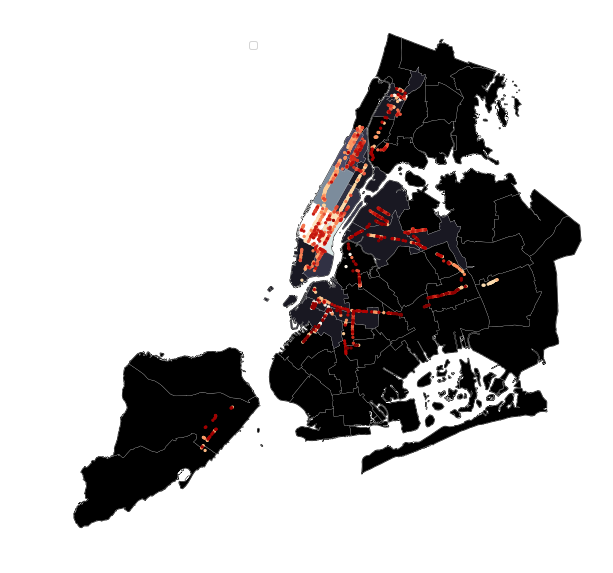

In [54]:
#plotting (plotting map underneath main choropleth cause i have NaNs
f, ax = cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black")
f, ax, c = cp.choroplethNYC(pumashplc, column="linkNYCpp", scheme='equal_interval', k=10,
                                    cmap="bone", ax=ax, edgecolor="white", lw=0.2)
linkNYC.plot(marker='o', c="date_link_", 
             markersize=5, cmap="OrRd", ax=ax);

##### Fig. 4: Map of linkNYC locations (dots as in Fig. 3) and number of linkNYC per 100 inhabitants, in equal intervals as indicated in the caption. The high concentration of linkNYC hubs in Manhattan is reflected by the brighter color of the PUMAs in this area: despite generally being the most populated areas, the midtown and lower Manhattan pumas have the highest number of linkNYC per inhabitant.

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

In [55]:
pumashplc.linkNYCpp

index_right
0      0.065920
1           NaN
2           NaN
3           NaN
4      0.119284
5           NaN
6      0.049727
7      1.569859
8      1.873385
9      1.787649
10     1.299590
11          NaN
12     0.948104
13     0.792910
14     1.156069
15     0.499319
16     5.752841
17          NaN
18     4.478708
19     2.379286
20     3.973139
21     8.048290
22    15.141540
23    13.247173
24     3.455964
25     1.588142
26     0.189036
27     1.192748
28          NaN
29     1.029654
30     0.056850
31     0.350000
32     1.599016
33     1.694915
34     0.591716
35     0.538358
36     0.450857
37          NaN
38          NaN
39          NaN
40     1.704545
41     0.884132
42          NaN
43          NaN
44          NaN
45          NaN
46     1.767215
47     1.420959
48     2.689873
49          NaN
50     1.280410
51     0.456853
52          NaN
53          NaN
54          NaN
Name: linkNYCpp, dtype: float64

In [56]:
pumashplc["loglinkNYCpp"] = np.log10(pumashplc["linkNYCpp"])
pumashplc["loglinkNYCpp"][~np.isfinite(pumashplc["loglinkNYCpp"])] = \
        pumashplc["loglinkNYCpp"][np.isfinite(pumashplc["loglinkNYCpp"])].min() - 1


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
pumashplc.linkNYCpp[np.isnan(pumashplc.linkNYCpp)] = np.nanmin(pumashplc.linkNYCpp)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'number of PUMAs')

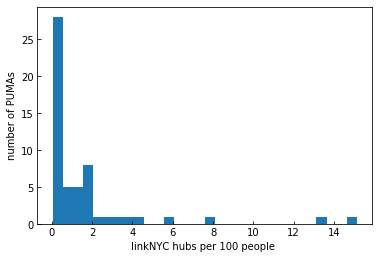

In [58]:
ax = pl.figure().add_subplot(111)
ax.hist(pumashplc.linkNYCpp, bins=30);
ax.set_xlabel("linkNYC hubs per 100 people ")
ax.set_ylabel("number of PUMAs")

##### Fig. 5: Number of linkNYC hubs per 100 people by PUMA. Most PUMAs have none, or anyhow less than 2  hubs per 100 people, with a maximum of 15.

In [59]:
pumashplc.describe()

,puma,shape_area,shape_leng,B28002_004E,state_x,public use microdata area_x,B28002_001E,pcBB,B00001_001E,state_y,public use microdata area_y,Unnamed: 4,link_site,linkNYCpp,loglinkNYCpp
count,55.000000,5.500000e+01,55.000000,55.000000,55.0,55.000000,55.000000,55.000000,55.000000,55.0,55.000000,0.0,37.000000,55.000000,55.000000
mean,3936.218182,1.532632e+08,91547.959548,45287.254545,36.0,3936.218182,56633.272727,79.462797,2138.618182,36.0,3936.218182,NaN,38.216216,1.582166,-0.727881
std,149.997616,1.361440e+08,77522.481125,14410.514427,0.0,149.997616,14874.212875,7.548276,699.237163,0.0,149.997616,NaN,46.499782,2.924306,1.209438
min,3701.000000,3.984279e+07,34852.437966,27834.000000,36.0,3701.000000,37998.000000,54.932945,1238.000000,36.0,3701.000000,NaN,1.000000,0.049727,-2.303412
25%,3804.500000,7.498814e+07,48072.809133,35658.500000,36.0,3804.500000,45822.500000,74.772059,1554.000000,36.0,3804.500000,NaN,12.000000,0.049727,-2.303412
50%,4005.000000,1.070001e+08,70492.955589,41578.000000,36.0,4005.000000,52591.000000,79.301693,2004.000000,36.0,4005.000000,NaN,25.000000,0.538358,-0.268929
75%,4059.500000,1.692189e+08,98789.538654,50273.000000,36.0,4059.500000,62501.500000,85.127599,2383.500000,36.0,4059.500000,NaN,40.000000,1.646966,0.216500
max,4114.000000,6.760200e+08,412606.741739,102520.000000,36.0,4114.000000,111507.000000,93.030650,4001.000000,36.0,4114.000000,NaN,230.000000,15.141540,1.180170


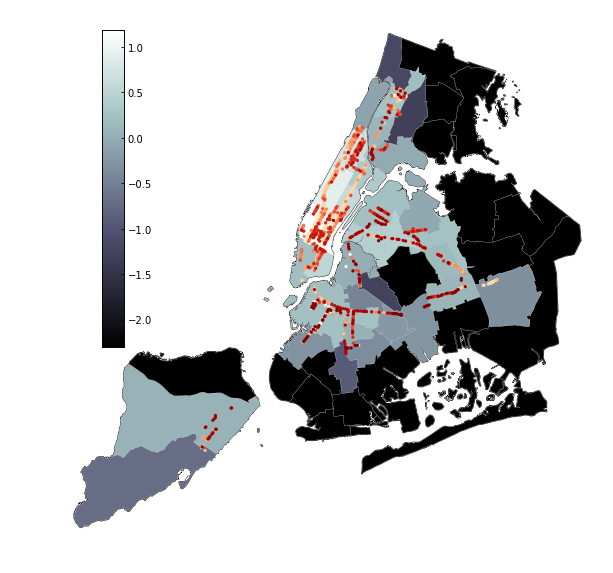

In [60]:
#plotting (plotting map underneath main choropleth cause i have NaNs
f, ax = cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black")
f, ax, c = cp.choroplethNYC(pumashplc, column="loglinkNYCpp",
                                    cmap="bone", ax=ax, edgecolor="white", lw=0.2)
linkNYC.plot(marker='o', c="date_link_", 
             markersize=5, cmap="OrRd", ax=ax);

##### Fig. 6: As Fig 4, but with the number of linkNYC per person plotted in a logaritmic scale: this scaling allows to isolate PUMA with no linkNYC hubs from PUMAs with few linkNYC hubs per person and reduces the gradient allowing to see differences in the linkNYC per inhabitant in PUMAs in the outer borroughs.

## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


## in order to account for neighbouring PUMAs with stations create a spatial weights matrix to assess neighbour distances for the PUMA geometries - we use queens weights. For theoretical details on this see:
# [Anselin Rey & Li 2014](http://www.tandfonline.com/doi/full/10.1080/13658816.2014.917313?scroll=top&needAccess=true)

In [61]:
import pysal as ps
qW_CT = ps.weights.Queen.from_dataframe(pumashp)

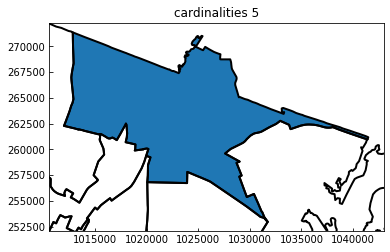

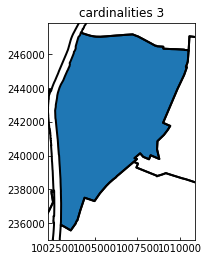

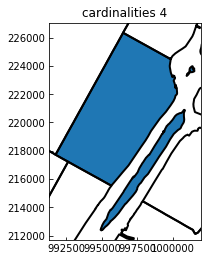

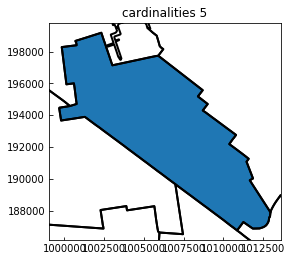

In [62]:
#cardinalities of the 10th puma
for i in 1, 10, 20, 30:
    ax = pumashp[i:i+1].plot()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax = pumashp.plot(color="None",ax=ax, linewidth=2, edgecolor="k")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("cardinalities %d"%qW_CT.cardinalities[i])

In [63]:
# the weight matrix
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [64]:
qW_CT.transform = 'r'
pumashplc["linkNYCpponBBpercentagesq"] = (pumashplc["linkNYCpp"] / 
                                          (pumashplc.pcBB / 100))
linkedNYCLag = ps.lag_spatial(qW_CT, pumashplc["linkNYCpponBBpercentagesq"])

linkedNYCpc = ps.Percentiles(linkedNYCLag.squeeze(), [0,25,50,75,100])
linkedNYCpc.yb

array([2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 3, 1, 2, 4, 3, 2, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 1, 3, 4, 2, 3, 4, 3, 2, 2, 2, 1, 1, 1, 4, 3, 2, 1,
       1, 2, 3, 3, 4, 3, 2, 1, 2, 0, 1])

In [65]:
pumashplc["sqlinkNYCpponBBpercentagesq"] = (np.sqrt(pumashplc["linkNYCpp"])**0.5 / 
                                            (pumashplc.pcBB / 100)**2)
linkedNYCLag2 = ps.lag_spatial(qW_CT, pumashplc["sqlinkNYCpponBBpercentagesq"])
linkedNYCpc2 = ps.Percentiles(linkedNYCLag2.squeeze(), [0,25,50,75,100])
linkedNYCpc2.yb

array([3, 1, 1, 1, 2, 1, 3, 2, 4, 3, 4, 2, 2, 4, 2, 1, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 1, 3, 4, 3, 3, 4, 3, 2, 2, 3, 2, 1, 1, 3, 3, 2, 1,
       1, 2, 2, 2, 3, 3, 2, 1, 2, 0, 1])

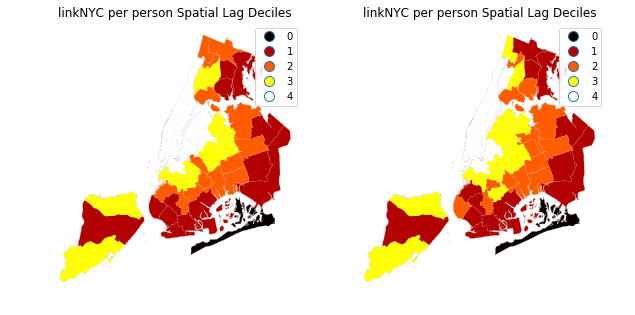

In [66]:
#f, ax = plt.subplots(figsize=(9, 9))
f = pl.figure(figsize=(10, 5))
ax = f.add_subplot(121)
pumashp.plot(color='white', edgecolor='black', ax=ax, lw=0.1)
pumashplc.assign(cl=linkedNYCpc.yb).plot(column='cl', categorical=True, 
        k=5, cmap='hot', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("linkNYC per person Spatial Lag Deciles");
ax = f.add_subplot(122)
pumashp.plot(color='white', edgecolor='black', ax=ax, lw=0.1)
pumashplc.assign(cl=linkedNYCpc2.yb).plot(column='cl', categorical=True, 
        k=5, cmap='hot', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("linkNYC per person Spatial Lag Deciles");

##### Fig. 7: Two metrics of the impact of linkNYC hubs,  constructed one, *on the left*, as the ratio of linkNYC per 100 inhabitants ($N_{linkNYC_{100}}$) over the fraction of houses with broadband access ($f_{BB}$): $ \frac{N_{linkNYC_{100}}}{f_{BB}}$ and *on the right*  the square root of the linkNYC hubs per 100 people over the square of the  fraction of houses with broadband access. $ \frac{\sqrt{N_{linkNYC_{100}}}}{f_{BB}^2}$, giving less weight to the presence of linkNYC hubs and more wight to the BB fraction. Both are aggregated and plotted as  spatial lag deciles (the average of the values for the neighbouring regions) with queen's weights (Anselin, Rey & Li 2014) at the PUMA geographic granularity level.  Small differences are visible in the impact of linkNYC in the Bronx and in Brooklyn,  where the second metric shows a higher impact, and Queens where the impact measured by the second metric is less.   Colors from black through red and yellow to white indicate higher impact of linkNYC as defined above. The area of highest impact are in Manhattan and the Brooklyn PUMAs that face the East river: with this metric the linkNYC aboundance in midtown Manhattan dominates the metric. 


Note: To find the table you extracted through the API manually you could

https://factfinder.census.gov/ -> Advanced Search -> Show me all 
    
    - Topics: Housing -> Physical Characteristics -> Internet Access
    - Geographies -> all geography types -> Public Use Microdata Areas (755)
                     -> Select a State: New York -> All Pubic Use Microdaa Areas within New York
                     -> Add Your Selection
    - Years -> 2016